In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpytorch as gp
import torch

np.random.seed(42)



## Manual gp

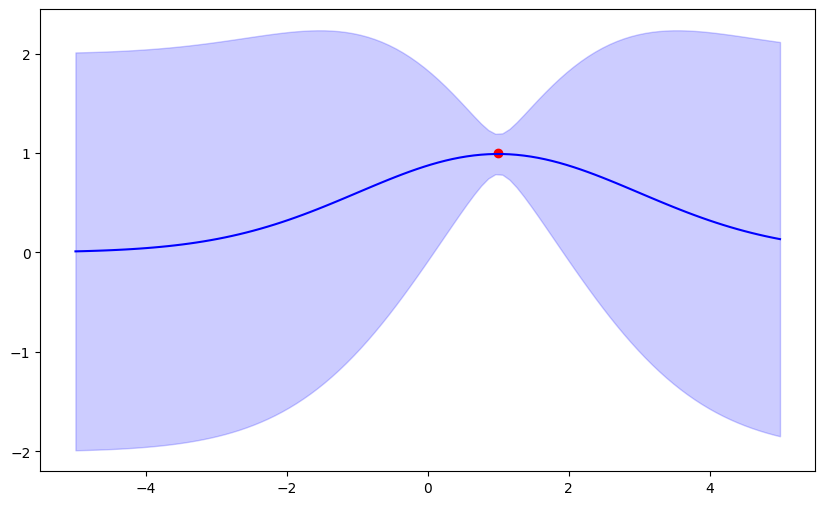

In [14]:
sigma_f = 1.0
sigma_n = 0.1
l = 2.0

def get_kernel(sigma_f, l):
    return lambda x, x_: sigma_f * np.exp(-0.5 * ((x - x_) / l) ** 2)

def predict(X_train, y_train, X_test, l, sigma_f, sigma_n):
    k = get_kernel(sigma_f, l)

    def K(X):
        X = np.asarray(X)
        d2 = (X[:, None] - X[None, :]) ** 2
        return sigma_f * np.exp(-0.5 * d2 / (l ** 2))

    mus = []
    vars = []


    for x in X_test:
        k_star = np.array([k(x, x_i) for x_i in X_train])
        inv = np.linalg.inv(K(X_train) + sigma_n ** 2 * np.eye(len(X_train)))
        mu = k_star @ inv @ y_train
        var = k(x, x) - k_star @ inv @ k(X_train, x)
        mus.append(mu)
        vars.append(var)
    mus = np.array(mus)
    vars = np.array(vars)

    return mus, vars

X_train = np.array([1.0])
y_train = np.array([1.0])

X_test = np.linspace(-5, 5, 100)
mus, vars = predict(X_train, y_train, X_test, l, sigma_f, sigma_n)

# plot
plt.figure(figsize=(10, 6))
plt.plot(X_test, mus, label='Predictive Mean', color='blue')
plt.fill_between(X_test, mus - 2 * np.sqrt(vars), mus + 2 * np.sqrt(vars), color='blue', alpha=0.2)
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.show()



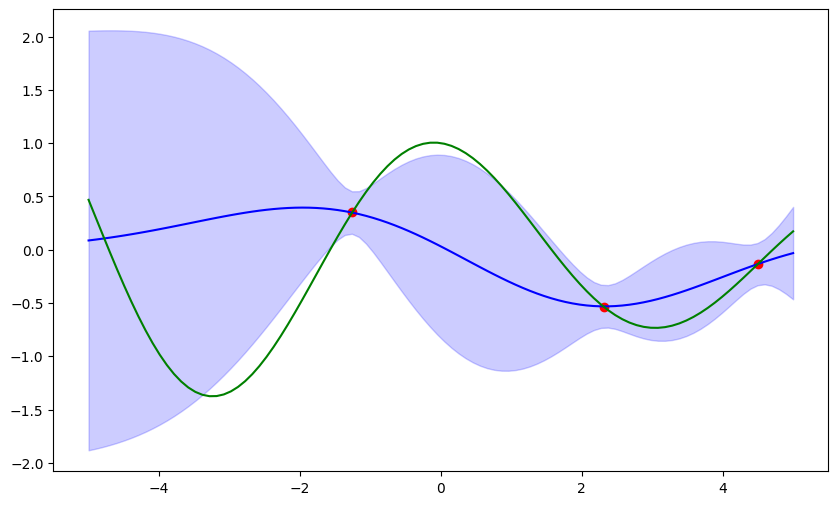

In [15]:
f = lambda x: np.cos(x) * np.exp(-0.1 * x)


np.random.seed(42)
X_train = np.random.uniform(-5, 5, 3)
y_train = f(X_train)
X_test = np.linspace(-5, 5, 100)

mus, vars = predict(X_train, y_train, X_test, l, sigma_f, sigma_n)

# plot
plt.figure(figsize=(10, 6))
plt.plot(X_test, mus, label='Predictive Mean', color='blue')
plt.fill_between(X_test, mus - 2 * np.sqrt(vars), mus + 2 * np.sqrt(vars), color='blue', alpha=0.2)
plt.plot(X_test, f(X_test), label='True Function', color='green')
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.show()

### Hyperparameter sensitivity study

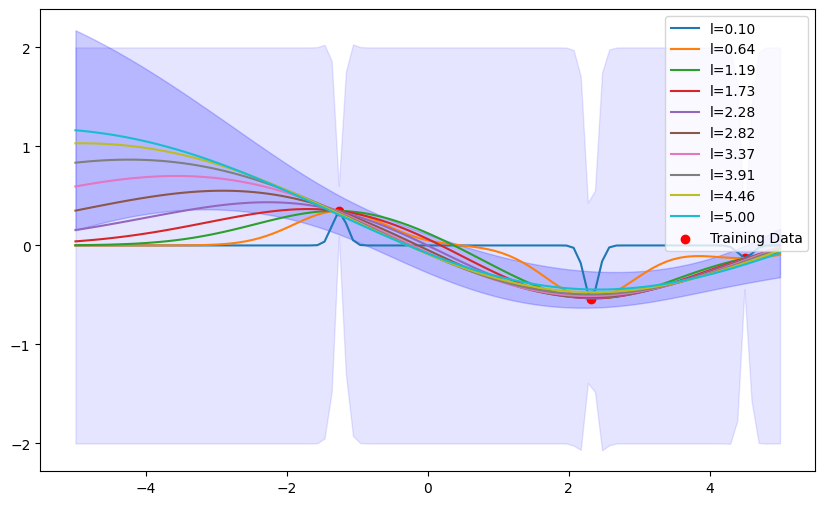

In [16]:
l_space = np.linspace(0.1, 5.0, 10)
l_means = []
l_vars = []

sigma_f = 1.0
sigma_n = 0.1

for l in l_space:
    mus, vars = predict(X_train, y_train, X_test, l, sigma_f, sigma_n)
    l_means.append(mus)
    l_vars.append(vars)

# plot
plt.figure(figsize=(10, 6))
for i, l in enumerate(l_space):
    plt.plot(X_test, l_means[i], label=f'l={l:.2f}')
plt.fill_between(X_test, l_means[0] - 2 * np.sqrt(l_vars[0]), l_means[0] + 2 * np.sqrt(l_vars[0]), color='blue', alpha=0.1)
plt.fill_between(X_test, l_means[-1] - 2 * np.sqrt(l_vars[-1]), l_means[-1] + 2 * np.sqrt(l_vars[-1]), color='blue', alpha=0.2)
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.legend()
plt.show()


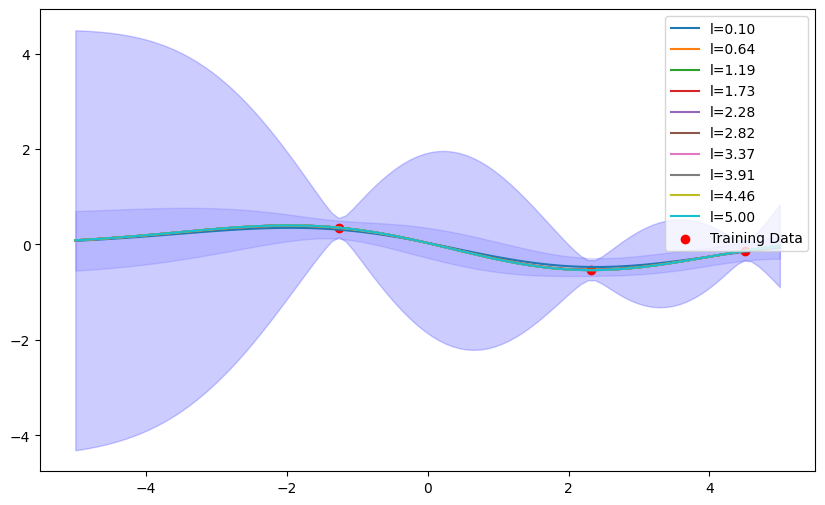

In [17]:
sigma_f_space = np.linspace(0.1, 5.0, 10)
sigma_f_means = []
sigma_f_vars = []

l = 2.0
sigma_n = 0.1

for sigma_f in sigma_f_space:
    mus, vars = predict(X_train, y_train, X_test, l, sigma_f, sigma_n)
    sigma_f_means.append(mus)
    sigma_f_vars.append(vars)

# plot
plt.figure(figsize=(10, 6))
for i, l in enumerate(sigma_f_space):
    plt.plot(X_test, sigma_f_means[i], label=f'l={l:.2f}')
plt.fill_between(X_test, sigma_f_means[0] - 2 * np.sqrt(sigma_f_vars[0]), sigma_f_means[0] + 2 * np.sqrt(sigma_f_vars[0]), color='blue', alpha=0.1)
plt.fill_between(X_test, sigma_f_means[-1] - 2 * np.sqrt(sigma_f_vars[-1]), sigma_f_means[-1] + 2 * np.sqrt(sigma_f_vars[-1]), color='blue', alpha=0.2)
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.legend()
plt.show()

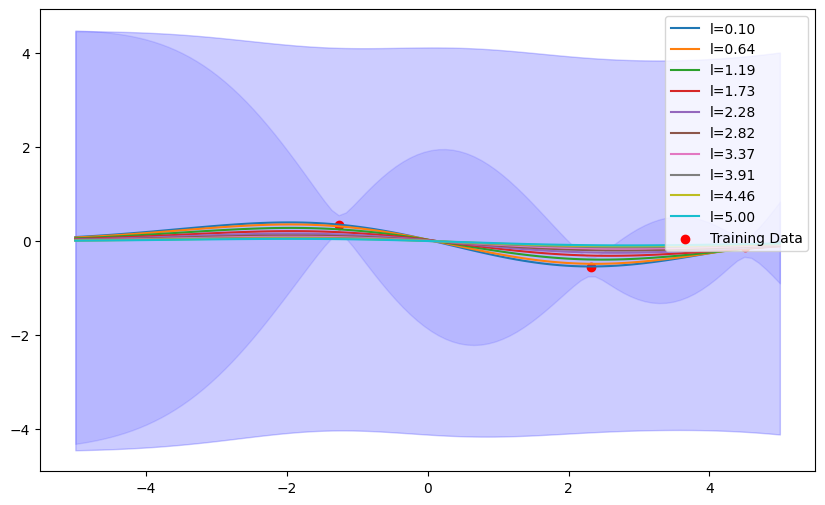

In [18]:
sigma_n_space = np.linspace(0.1, 5.0, 10)
sigma_n_means = []
sigma_n_vars = []

l = 2.0
sigma_n = 0.1

for sigma_n in sigma_n_space:
    mus, vars = predict(X_train, y_train, X_test, l, sigma_f, sigma_n)
    sigma_n_means.append(mus)
    sigma_n_vars.append(vars)

# plot
plt.figure(figsize=(10, 6))
for i, l in enumerate(sigma_n_space):
    plt.plot(X_test, sigma_n_means[i], label=f'l={l:.2f}')
plt.fill_between(X_test, sigma_n_means[0] - 2 * np.sqrt(sigma_n_vars[0]), sigma_n_means[0] + 2 * np.sqrt(sigma_n_vars[0]), color='blue', alpha=0.1)
plt.fill_between(X_test, sigma_n_means[-1] - 2 * np.sqrt(sigma_n_vars[-1]), sigma_n_means[-1] + 2 * np.sqrt(sigma_n_vars[-1]), color='blue', alpha=0.2)
plt.scatter(X_train, y_train, color='red', label='Training Data')
plt.legend()
plt.show()

## Toolbox gp

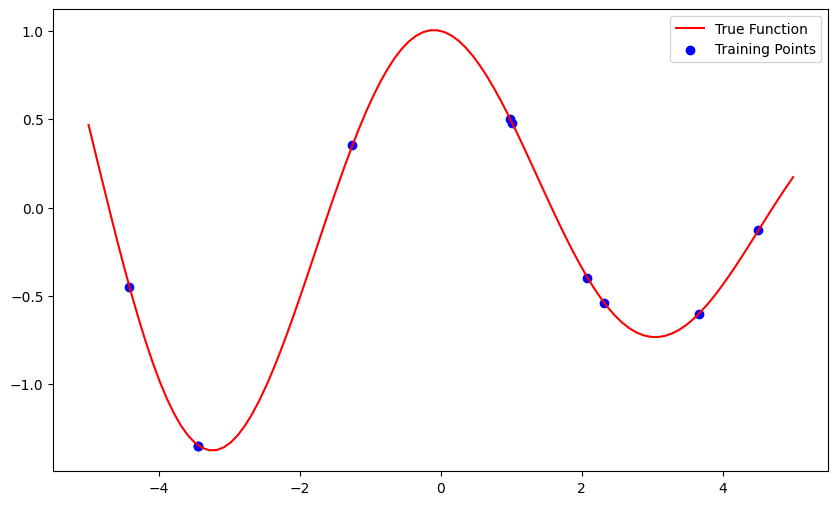

In [7]:

f = lambda x: np.cos(x) * np.exp(-0.1 * x)

np.random.seed(42)
X_train = np.random.uniform(-5, 5, 10)
y_train = f(X_train)

X_test = np.linspace(-5, 5, 100)

X_star = torch.linspace(-6, 6, 200)

train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)

# plot
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), label='True Function', color='red')
plt.scatter(X_train, f(X_train), label='Training Points', color='blue')
plt.legend()
plt.show()

In [11]:

likelihood = gp.likelihoods.GaussianLikelihood()

def plot_gp(model, X_star, train_x, train_y):
    model.eval(); likelihood.eval()

    with torch.no_grad(), gp.settings.fast_pred_var():
        posterior = model(X_star)
        mean = posterior.mean
        lower, upper = posterior.confidence_region()
        y_pred = likelihood(model(X_star)).mean

    model.train(); likelihood.train()

    fig = plt.figure(figsize=(10, 6))
    plt.plot(X_star.numpy(), mean.numpy(), 'b', label='Predictive Mean')
    plt.fill_between(X_star.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence Interval')
    plt.scatter(train_x.numpy(), train_y.numpy(), c='r', marker='o', label='Training Data')
    plt.plot(X_star.numpy(), f(X_star.numpy()), 'g', label='True Function')
    plt.legend()
    plt.close(fig)
    return fig

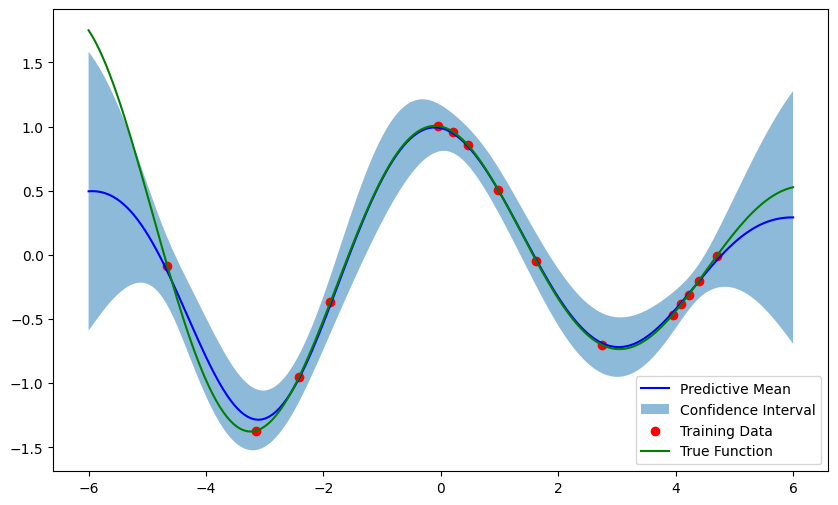

In [12]:
num_iters = 40

def initialize_and_train(train_x, train_y):
    class ExactGPModel(gp.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gp.means.ConstantMean()
            self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gp.distributions.MultivariateNormal(mean_x, covar_x)

    model = ExactGPModel(train_x, train_y, likelihood)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gp.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train(); likelihood.train()
    for i in range(num_iters):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return model



model = initialize_and_train(train_x, train_y)
plot_gp(model, X_star, train_x, train_y)


### Dependence on number of input points

/tmp/ipykernel_23119/2328744986.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = lambda x: np.cos(x) * np.exp(-0.1 * x)


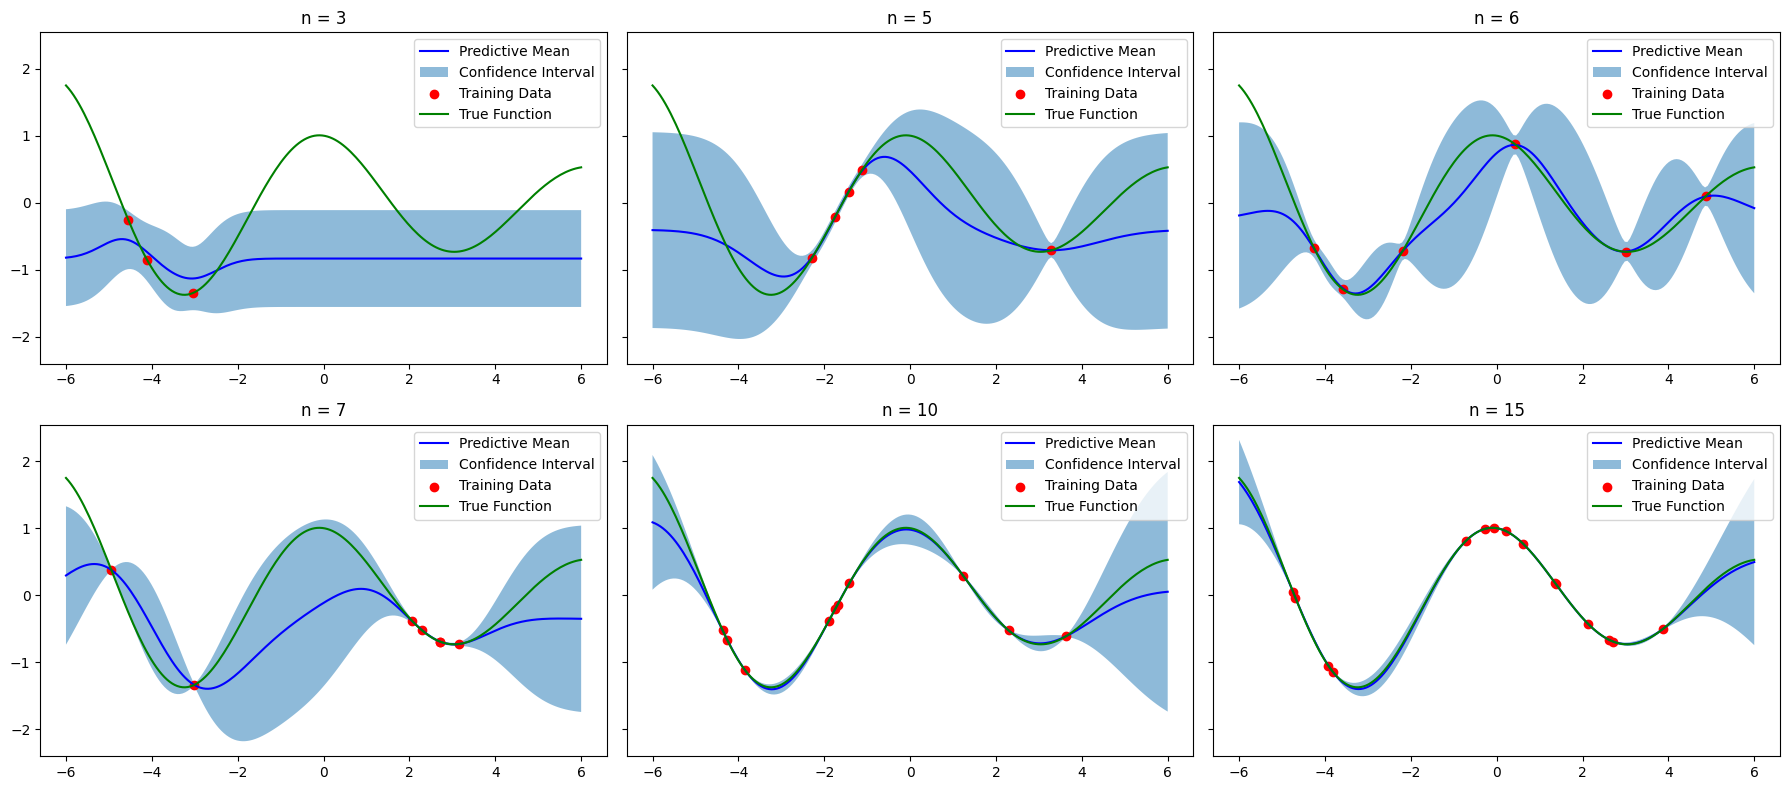

In [13]:
X_star = torch.linspace(-6, 6, 200)

num_points = [3, 5, 6, 7, 10, 15]

figs = []
ncols = min(3, len(num_points))
nrows = int(np.ceil(len(num_points) / ncols))
fig, axs = plt.subplots(nrows, ncols,
                        figsize=(6 * ncols, 4 * nrows),
                        sharey=True)

for ax, n in zip(axs.ravel(), num_points):
    X_train = np.random.uniform(-5, 5, n)
    y_train = f(X_train)
    train_x = torch.tensor(X_train, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32)
    model = initialize_and_train(train_x, train_y)


    model.eval(); likelihood.eval()
    with torch.no_grad(), gp.settings.fast_pred_var():
        posterior = model(X_star)
        mean = posterior.mean.detach().cpu().numpy()
        lower, upper = posterior.confidence_region()
        lower = lower.detach().cpu().numpy()
        upper = upper.detach().cpu().numpy()

    # plot on the provided axis
    ax.plot(X_star.numpy(), mean, 'b', label='Predictive Mean')
    ax.fill_between(X_star.numpy(), lower, upper, alpha=0.5, label='Confidence Interval')
    ax.scatter(train_x.numpy(), train_y.numpy(), c='r', marker='o', label='Training Data')
    ax.plot(X_star, f(X_star), label='True Function', color='green')
    ax.set_title(f'n = {n}')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()